In [1]:
from plantcv import plantcv as pcv
import numpy as np

In [2]:
class options:
    def __init__(self):
        self.image = "C:/Users/Beth/Desktop/JL Lab/Egregious Pictures/Aww yikes/12-55-28.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "./multi_plant_tutorial_results"
        self.outdir = "." # Store the output to the current directory 

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug


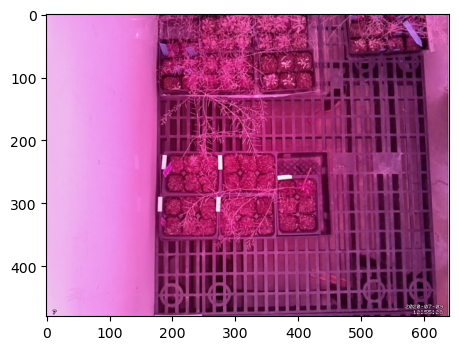

In [3]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

In [4]:
# Check if this is a night image, for some of these dataset's images were captured
# at night, even if nothing is visible. To make sure that images are not taken at
# night we check that the image isn't mostly dark (0=black, 255=white).
# if it is a night image it throws a fatal error and stops the workflow.

if np.average(img) < 50:
    pcv.fatal_error("Night Image")
else:
    pass

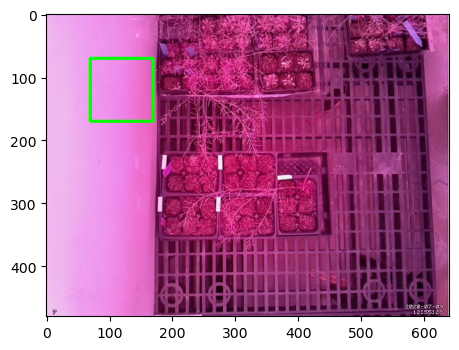

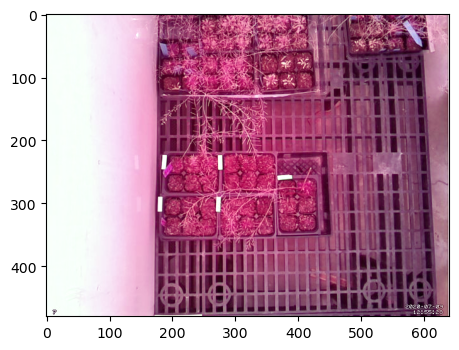

In [9]:
# Normalize the white color so you can later
# compare color between images.

# Inputs:
#   img = image object, RGB color space
#   roi = region for white reference, if none uses the whole image,
#         otherwise (x position, y position, box width, box height)

# white balance image based on white toughspot
img1 = pcv.white_balance(img, roi=(70,70,100,100))


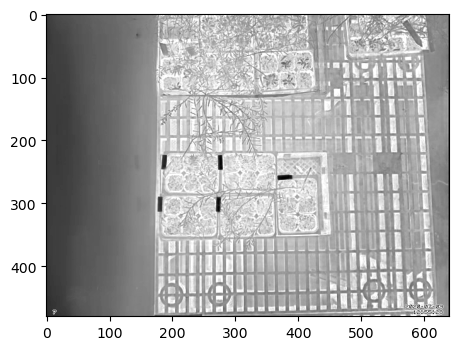

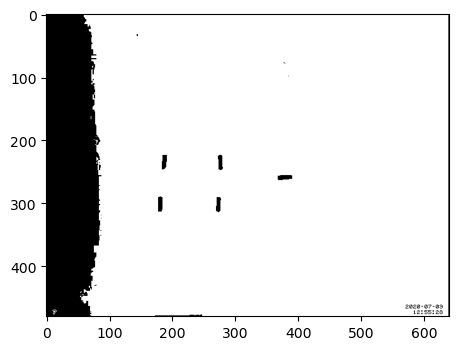

In [10]:
# Convert RGB to HSV and extract the saturation channel
# Then set threshold for saturation
s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
s_thresh = pcv.threshold.binary(gray_img=s, 
                                threshold=90, 
                                max_value=255, 
                                object_type='light')

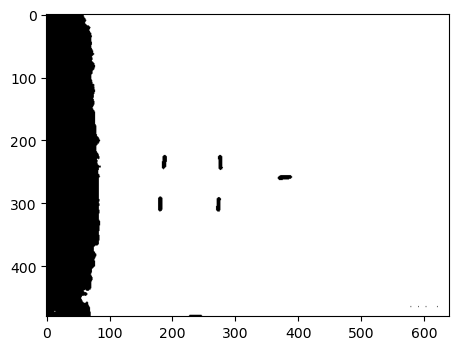

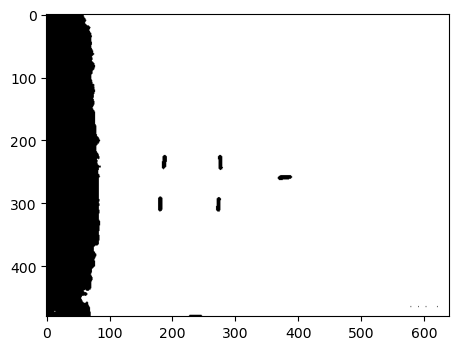

In [11]:
# Set Median Blur
#Input box size "ksize" 
s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=5)
s_cnt = pcv.median_blur(gray_img=s_thresh, ksize=5)

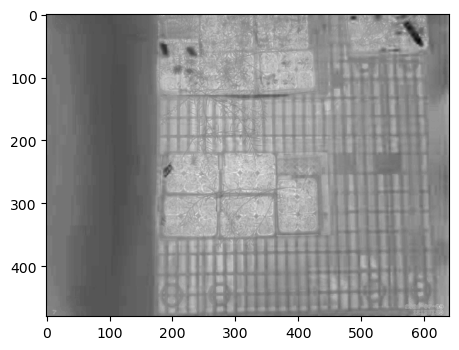

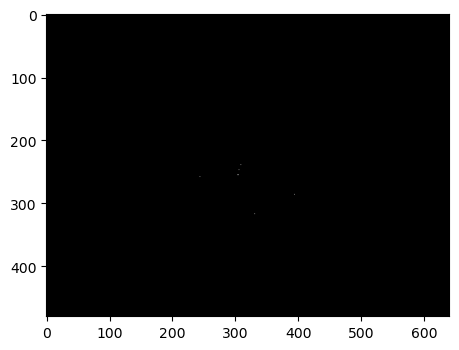

In [12]:
# Convert RGB to LAB and extract the blue channel
#Then threshold the image
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')
b_thresh = pcv.threshold.binary(gray_img=b, 
                                threshold=145, 
                                max_value=255, 
                                object_type='light')

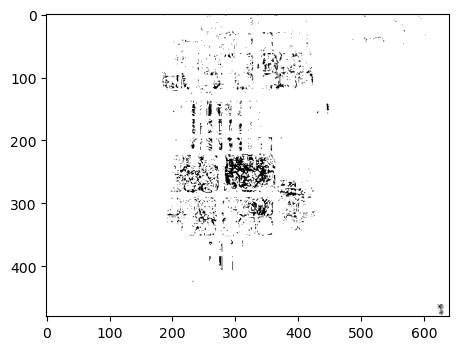

In [13]:
#Setting threshold continued
b_cnt = pcv.threshold.binary(gray_img=b, 
                             threshold=130, 
                             max_value=255, 
                             object_type='dark')

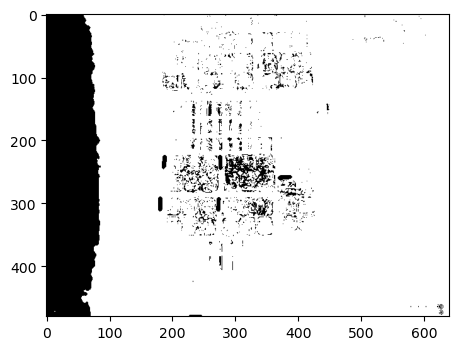

In [14]:
#Join the blue and yellow binary images
bs = pcv.logical_and(bin_img1=s_mblur, bin_img2=b_cnt)

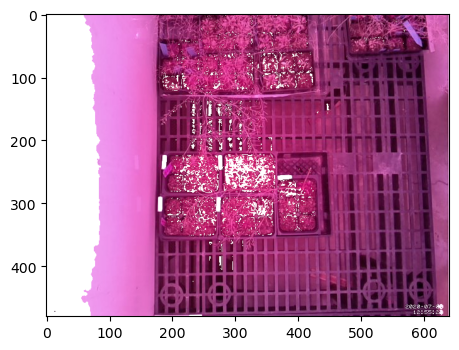

In [15]:
masked = pcv.apply_mask(img=img, 
                        mask=bs, 
                        mask_color='white')

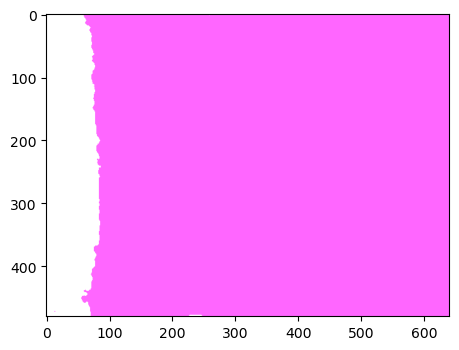

In [16]:
#identify objects
obj2 = id_objects,obj_hierarchy = pcv.find_objects(img=masked, mask=bs)

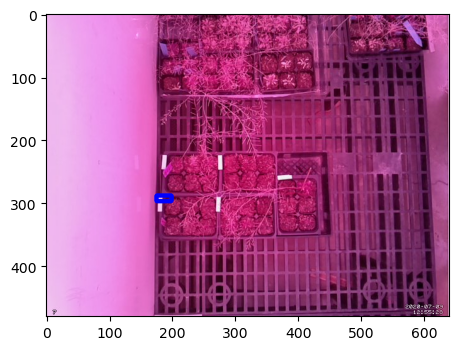

In [19]:
#Define Range of Intrest
# Inputs: 
    #   img - RGB or grayscale image to plot the ROI on 
    #   x - The x-coordinate of the upper left corner of the rectangle 
    #   y - The y-coordinate of the upper left corner of the rectangle 
    #   h - The height of the rectangle 
    #   w - The width of the rectangle 
roi1, roi_hierarchy= pcv.roi.rectangle(img=img, x=175, y=288, h=10, w=25)

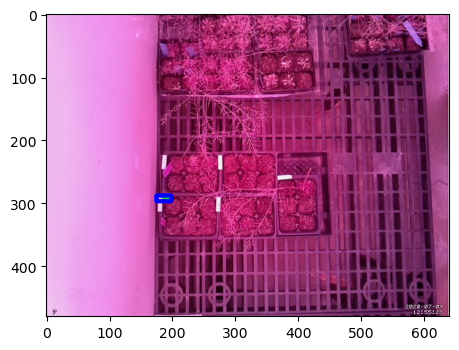

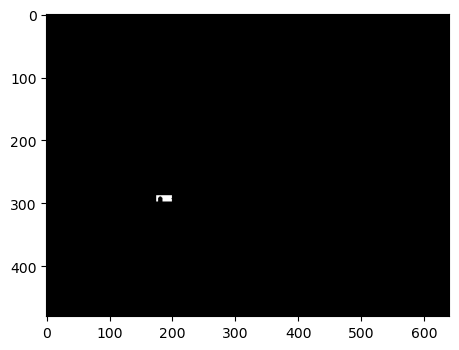

In [20]:
 # Decide which objects to keep

    # Inputs:
    #    img            = img to display kept objects
    #    roi_contour    = contour of roi, output from any ROI function
    #    roi_hierarchy  = contour of roi, output from any ROI function
    #    object_contour = contours of objects, output from pcv.find_objects function
    #    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
    #    roi_type       = 'partial' (default, for partially inside), 'cutto', or 
    #    'largest' (keep only largest contour)
roi_objects, hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                                  roi_hierarchy=roi_hierarchy,
                                                                  object_contour=id_objects,
                                                                  obj_hierarchy=obj_hierarchy,
                                                                  roi_type='cutto')


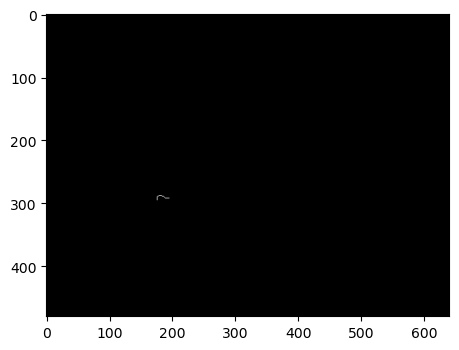

In [21]:
# Skeletonize the mask 
#%matplotlib notebook
# To enable the zoom feature to better see fine lines, uncomment the line above ^^ 
skeleton = pcv.morphology.skeletonize(mask=kept_mask)

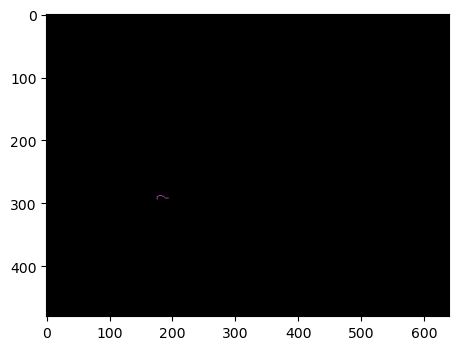

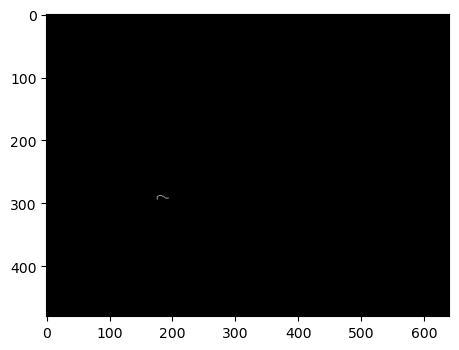

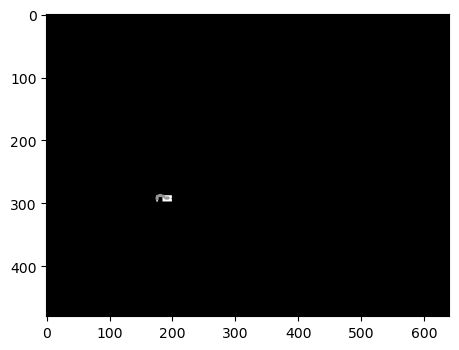

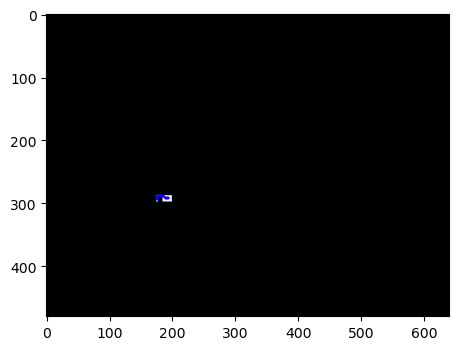

In [22]:
##############Skeletonize#########
# Adjust line thickness with the global line thickness parameter (default = 5),
    # and provide binary mask of the plant for debugging. NOTE: the objects and
    # hierarchies returned will be exactly the same but the debugging image (segmented_img)
    # will look different.
pcv.params.line_thickness = 3 

    # Prune the skeleton  

    # Inputs:
    #   skel_img = Skeletonized image
    #   size     = Pieces of skeleton smaller than `size` should get removed. (Optional) Default `size=0`. 
    #   mask     = Binary mask for debugging (optional). If provided, debug images will be overlaid on the mask.

pruned, seg_img, edge_objects = pcv.morphology.prune(skel_img=skeleton, 
                                                     size=170, 
                                                     mask=kept_mask)
pcv.params.debug = "plot"

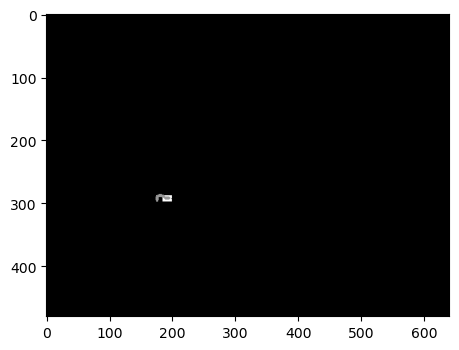

In [23]:
# Identify branch points   

# Inputs:
#   skel_img = Skeletonized image
#   mask     = (Optional) binary mask for debugging. If provided, debug image will be overlaid on the mask.
branch_pts_mask = pcv.morphology.find_branch_pts(skel_img=skeleton, 
                                                 mask=kept_mask)


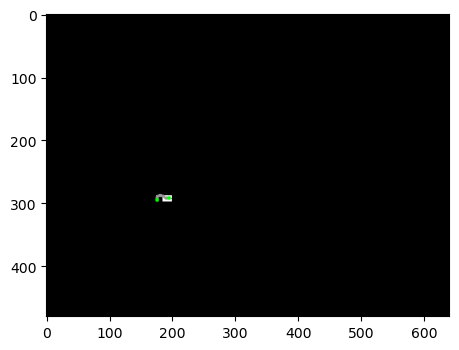

In [24]:
# Identify tip points   

# Inputs:
#   skel_img = Skeletonized image
#   mask     = (Optional) binary mask for debugging. If provided, debug 
#              image will be overlaid on the mask.
tip_pts_mask = pcv.morphology.find_tips(skel_img=skeleton, 
                                        mask=kept_mask)


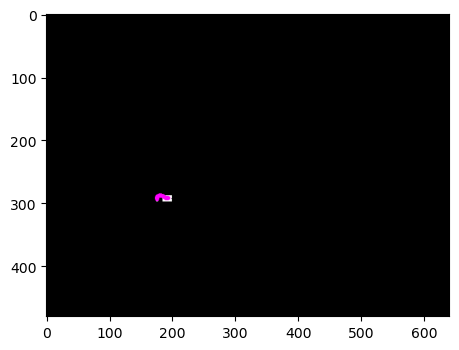

In [25]:
# Adjust line thickness with the global line thickness parameter (default = 5),
# and provide binary mask of the plant for debugging. NOTE: the objects and
# hierarchies returned will be exactly the same but the debugging image (segmented_img)
# will look different.
pcv.params.line_thickness = 5
# Sort segments into primary (stem) objects and secondary (leaf) objects. 
# Downstream steps can be performed on just one class of objects at a time, 
# or all objects (output from segment_skeleton) 
  
# Inputs:
#   skel_img  = Skeletonized image
#   objects   = List of contours
#   mask      = (Optional) binary mask for debugging. If provided, debug image will be overlaid on the mask.
leaf_obj, stem_obj = pcv.morphology.segment_sort(skel_img=skeleton, 
                                                 objects=edge_objects,
                                                 mask=kept_mask)


In [26]:
# Identify segments     

# Inputs:
#   skel_img  = Skeletonized image
#   objects   = List of contours
#   mask      = (Optional) binary mask for debugging. If provided, 
#               debug image will be overlaid on the mask.
segmented_img, labeled_img = pcv.morphology.segment_id(skel_img=skeleton, 
                                                       objects=leaf_obj, 
                                                       mask=kept_mask)


ZeroDivisionError: division by zero

In [21]:
# Similar to line thickness, there are optional text size and text thickness parameters 
# that can be adjusted to better suit images or varying sizes.
pcv.params.text_size=.8 # (default text_size=.55)
pcv.params.text_thickness=3 # (defaul text_thickness=2) 

segmented_img, labeled_img = pcv.morphology.segment_id(skel_img=skeleton,
                                                       objects=leaf_obj,
                                                       mask=kept_mask)

ZeroDivisionError: division by zero

In [22]:
# Measure path lengths of segments     

# Inputs:
#   segmented_img = Segmented image to plot lengths on
#   objects       = List of contours
labeled_img  = pcv.morphology.segment_path_length(segmented_img=segmented_img, 
                                                  objects=leaf_obj)


NameError: name 'segmented_img' is not defined

In [23]:
# Measure euclidean distance of segments      

# Inputs:
#   segmented_img = Segmented image to plot lengths on
#   objects       = List of contours
labeled_img = pcv.morphology.segment_euclidean_length(segmented_img=segmented_img, 
                                                      objects=leaf_obj)


NameError: name 'segmented_img' is not defined

In [24]:
# Measure curvature of segments      

# Inputs:
#   segmented_img = Segmented image to plot curvature on
#   objects       = List of contours
labeled_img = pcv.morphology.segment_curvature(segmented_img=segmented_img, 
                                               objects=leaf_obj)


NameError: name 'segmented_img' is not defined

In [25]:
# Measure the angle of segments      

# Inputs:
#   segmented_img = Segmented image to plot angles on
#   objects       = List of contours
labeled_img = pcv.morphology.segment_angle(segmented_img=segmented_img, 
                                           objects=leaf_obj)


NameError: name 'segmented_img' is not defined

In [26]:
# Measure the tangent angles of segments      

# Inputs:
#   segmented_img = Segmented image to plot tangent angles on
#   objects       = List of contours
#   size          = Size of ends used to calculate "tangent" lines
labeled_img = pcv.morphology.segment_tangent_angle(segmented_img=segmented_img, 
                                                   objects=leaf_obj, 
                                                   size=15)


NameError: name 'segmented_img' is not defined

In [27]:
# Measure the leaf insertion angles      

# Inputs:
#   skel_img         = Skeletonize image 
#   segmented_img    = Segmented image to plot insertion angles on
#   leaf_objects     = List of leaf contours
#   stem_objects     = List of stem objects 
#   size             = Size of the inner portion of each leaf to find a linear regression line
labeled_img = pcv.morphology.segment_insertion_angle(skel_img=skeleton,
                                                     segmented_img=segmented_img, 
                                                     leaf_objects=leaf_obj, 
                                                     stem_objects=stem_obj,
                                                     size=20)


NameError: name 'segmented_img' is not defined

In [28]:
# Measure the leaf insertion angles      

# Inputs:
#   skel_img         = Skeletonize image 
#   segmented_img    = Segmented image to plot insertion angles on
#   leaf_objects     = List of leaf contours
#   stem_objects     = List of stem objects 
#   size             = Size of the inner portion of each leaf to find a linear regression line
labeled_img = pcv.morphology.segment_insertion_angle(skel_img=skeleton,
                                                     segmented_img=segmented_img, 
                                                     leaf_objects=leaf_obj, 
                                                     stem_objects=stem_obj,
                                                     size=20)


NameError: name 'segmented_img' is not defined

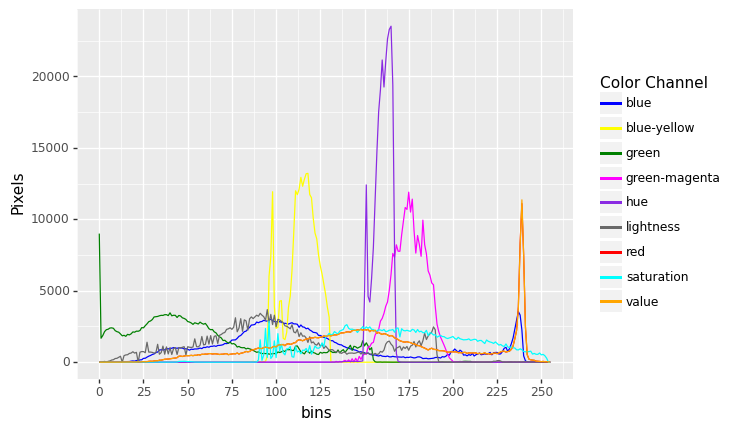

<ggplot: (-9223371944009329612)>


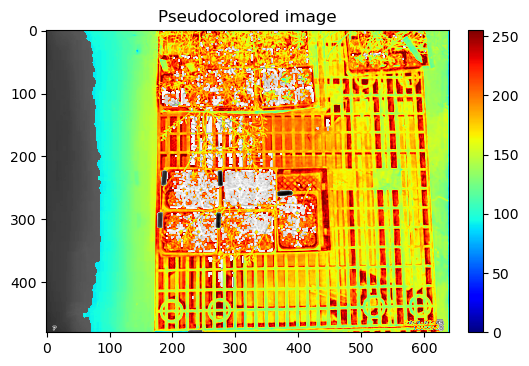

In [27]:
############### Analysis ################  

    # Find shape properties, output shape image (optional)

    # Inputs:
    #   img - RGB or grayscale image data 
    #   obj- Single or grouped contour object
    #   mask - Binary image mask to use as mask for moments analysis 
shape_img = pcv.analyze_object(img=img, 
                               obj=obj2, 
                               mask=bs)

    # Shape properties relative to user boundary line (optional)

    # Inputs:
    #   img - RGB or grayscale image data 
    #   obj - Single or grouped contour object 
    #   mask - Binary mask of selected contours 
    #   line_position - Position of boundary line (a value of 0 would draw a line 
    #                   through the bottom of the image) 
boundary_img1 = pcv.analyze_bound_horizontal(img=img, 
                                             obj=obj2, 
                                             mask=bs, 
                                             line_position=225)

    # Determine color properties: Histograms, Color Slices, output color analyzed histogram (optional)

    # Inputs:
    #   rgb_img - RGB image data
    #   mask - Binary mask of selected contours 
    #   hist_plot_type - None (default), 'all', 'rgb', 'lab', or 'hsv'
color_histogram = pcv.analyze_color(rgb_img=img, 
                                    mask=bs, 
                                    hist_plot_type='all')

    # Pseudocolor the grayscale image

    # Inputs:
    #     gray_img - Grayscale image data
    #     obj - Single or grouped contour object (optional), if provided the pseudocolored image gets 
    #           cropped down to the region of interest.
    #     mask - Binary mask (optional) 
    #     background - Background color/type. Options are "image" (gray_img, default), "white", or "black". A mask 
    #                  must be supplied.
    #     cmap - Colormap
    #     min_value - Minimum value for range of interest
    #     max_value - Maximum value for range of interest
    #     dpi - Dots per inch for image if printed out (optional, if dpi=None then the default is set to 100 dpi).
    #     axes - If False then the title, x-axis, and y-axis won't be displayed (default axes=True).
    #     colorbar - If False then the colorbar won't be displayed (default colorbar=True)
pseudocolored_img = pcv.visualize.pseudocolor(gray_img=s, 
                                              mask=bs, 
                                              cmap='jet')

    # Write shape and color data to results file
pcv.print_results(filename=args.result)

    # Will will print out results again, so clear the outputs before running NIR analysis 
pcv.outputs.clear()
